In [94]:
import pandas as pd
import numpy as np
import warnings; 
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')
#from sklearn.preprocessing import CategoricalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier

## Creating Test/Train Sets

In [74]:
file = pd.read_csv('../merged_any_master_schedule.csv')
test_cases = pd.read_csv('../test_cases_any_asylum_full_model.csv', header=None)

In [75]:
test_cases = test_cases.rename(columns={0:'num'})

In [76]:
train = file[~file.idncase.isin(test_cases.num)]

In [77]:
test = file[file.idncase.isin(test_cases.num)]

In [78]:
class Cleaning(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.drop(columns=['idncase', 'idnproceeding', 'adj_date', 'adj_time_start2', 'adj_time_stop2', 'osc_date_y'])
        X.loc[(X["dec"] == 'DENY'),'dec'] = 0
        X.loc[(X["dec"] == 'GRANT'),'dec'] = 1
        X['comp_date'] = pd.to_datetime(X['comp_date'],infer_datetime_format = True)
        startdate = np.datetime64('1984-07-11')
        X['comp_date_in_days'] = X['comp_date'].apply(lambda x: (x - startdate).days)
        X = X.drop(columns=['comp_date'], axis=1)
        return X
    

In [79]:
clean = Cleaning()
train_data = clean.transform(train)

In [80]:
y_train = train_data['dec']
X_train = train_data.drop(columns=['dec'], axis=1)

## Generating Pipeline

In [58]:
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        num_frame = X.select_dtypes(include=[self.dtype])
        self.names = num_frame.columns
        return num_frame
    def get_feature_names(self):
        return self.names.tolist()

In [59]:
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #X = np.asarray(pd.get_dummies(X))
        #self.names = X.columns 
        self.names = np.array(0)
        for col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            #cat_frame = X.apply(le.fit_transform)
            self.names = np.append(self.names, le.classes_)
    
        return X
    def get_feature_names(self):
        return self.names.tolist()

In [60]:
num_pipeline = Pipeline([
        ('selector', Selector(np.number)),
        ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
        ('selector', Selector('object')),
        ('labeler', CustomLabelEncoder())
        #('encoder', OneHotEncoder()),
]) 

full_pipeline = FeatureUnion(transformer_list=[ 
        ('numerical', num_pipeline),  
        ('categorical', cat_pipeline)   
])  

In [61]:
test = cat_pipeline.fit_transform(X_train)

In [62]:
len(cat_pipeline.named_steps['labeler'].get_feature_names())

1343

In [81]:
X_train_tr= full_pipeline.fit_transform(X_train)

## Hyperparameter Grid Search On Logistic Regression

In [30]:
param_grid = {'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [31]:
log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tr, y_train)
result = pd.DataFrame(grid_search.cv_results_)

/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/a

In [32]:
print(result)

    mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0        2.373631         0.013899         0.643052          0.726646   0.001   
1        2.424796         0.019857         0.669493          0.765314   0.001   
2       10.345317         0.032659         0.680687          0.776167    0.01   
3        4.903254         0.017303         0.694461          0.786889    0.01   
4       53.518398         0.022968         0.702331          0.792865     0.1   
5        9.248451         0.018657         0.704239          0.794846     0.1   
6      100.118109         0.015562         0.704828          0.796316       1   
7       21.231059         0.014013         0.704770          0.796598       1   
8       97.647666         0.013785         0.703872          0.796872      10   
9       41.358622         0.021417         0.703997          0.796837      10   
10      20.346499         0.018359         0.703046          0.796869     100   
11      51.879921         0.

In [33]:
final_model = grid_search.best_estimator_
feature_weight = np.abs(grid_search.best_estimator_.coef_[0])

In [ ]:
num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline.named_steps['labeler'].get_feature_names()
attributes = num_features + cat_features
indices = np.argsort(feature_weight_rf)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])

## Evaluate on Test Set

In [82]:
test_data = clean.transform(test)
y_test = test_data['dec']
X_test = test_data.drop(columns=['dec'], axis=1)
X_test_tr = full_pipeline.transform(X_test)

In [ ]:
#num_features = num_pipeline.named_steps['selector'].get_feature_names()
#cat_features = cat_pipeline.named_steps['labeler'].get_feature_names()

In [37]:
print(final_model.score(X_test_tr, y_test))

0.696774692252691


## Hyperparameter Grid Search On Decision Tree

In [83]:
param_grid_dt = {"max_depth": [10, 5, 3, 1, None],
        "max_features": randint(1, 20),
        "min_samples_leaf": randint(1, 20),
        "criterion": ["gini", "entropy"]}

In [84]:
dec_tree = DecisionTreeClassifier()
grid_search_dt = RandomizedSearchCV(dec_tree, param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_dt.fit(X_train_tr, y_train)
result = pd.DataFrame(grid_search_dt.cv_results_)
print(result)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       2.001384         0.239409         0.525180          0.610466   
1       4.919968         0.237922         0.617900          0.743138   
2       4.009336         0.314842         0.623042          0.734575   
3       1.691454         0.130752         0.557951          0.578748   
4       1.247001         0.060586         0.553210          0.595725   
5       1.144782         0.096876         0.509322          0.602275   
6      10.359612         0.146603         0.642793          0.978936   
7       9.214299         0.048461         0.708796          0.874548   
8       2.139269         0.131492         0.525180          0.610466   
9       2.082549         0.108281         0.696164          0.804679   

  param_criterion param_max_depth param_max_features param_min_samples_leaf  \
0         entropy               1                 14                      8   
1            gini               3                

In [86]:
final_model_dt = grid_search_dt.best_estimator_
print(final_model_dt.score(X_test_tr, y_test))

0.7174522194523354


Text(0.5,0,'Relative Importance')

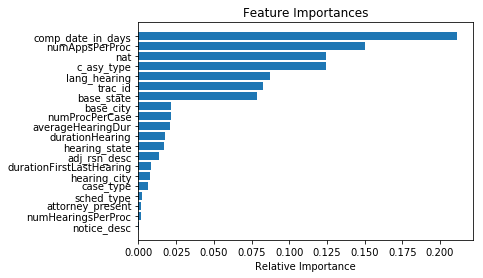

In [105]:
feature_weight_dt = grid_search_dt.best_estimator_.feature_importances_
num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline.named_steps['selector'].get_feature_names()
attributes = num_features + cat_features
indices = np.argsort(feature_weight_dt)
ordered_attributes = [attributes[i] for i in indices]

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_weight_dt[indices], align='center')
plt.yticks(range(len(indices)), ordered_attributes)
plt.xlabel('Relative Importance')

## Hyperparameter Grid Search On Decision Tree

In [106]:
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_features': [2, 4, 6, 8, 10],
    'bootstrap': [False, True],
    'max_depth':[2, 4, 6, 8]
}

In [ ]:
rf = RandomForestClassifier()
grid_search_rf = RandomizedSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train_tr, y_train)
result = pd.DataFrame(grid_search_rf.cv_results_)
print(result)

## Evaluate Random Forest Classifier on Test Set

In [ ]:
final_model_rf = grid_search_rf.best_estimator_
print(final_model_rf.score(X_test_tr, y_test))

In [ ]:
feature_weight_rf = grid_search_rf.best_estimator_.feature_importances_
indices_rf = np.argsort(feature_weight_rf)
ordered_attributes_rf = [attributes[i] for i in indices_rf]
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices_rf)), feature_weight_rf[indices_rf], align='center')
plt.yticks(range(len(indices_rf)), ordered_attributes_rf)
plt.xlabel('Relative Importance')